In [1]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# Installing this version of statsmodels as it has the plot_predict which gives the confidence interval for ARIMA predictions.
#!pip install statsmodels==0.12.1

In [3]:
covid_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv',index_col='date',parse_dates=True)

In [4]:
covid_df.tail()

,cases,deaths
date,,
2022-11-30,98518163,1087873
2022-12-01,98616721,1088564
2022-12-02,98690152,1088978
2022-12-03,98695013,1088997
2022-12-04,98699619,1088997


### LSTM

In [5]:
tf.random.set_seed(7)

In [6]:
# Read the dataset
dataframe = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [7]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test 
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [9]:
# convert an array of values into a dataset matrix
def get_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [10]:
# Reshaping 
look_back = 1
trainX, trainY = get_dataset(train, look_back)
testX, testY = get_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# LSTM modelling
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
700/700 - 2s - loss: 0.0242 - 2s/epoch - 2ms/step
Epoch 2/100
700/700 - 1s - loss: 0.0044 - 630ms/epoch - 900us/step
Epoch 3/100
700/700 - 1s - loss: 7.2810e-05 - 650ms/epoch - 929us/step
Epoch 4/100
700/700 - 1s - loss: 1.0544e-05 - 675ms/epoch - 965us/step
Epoch 5/100
700/700 - 1s - loss: 9.7989e-06 - 677ms/epoch - 968us/step
Epoch 6/100
700/700 - 1s - loss: 8.5109e-06 - 720ms/epoch - 1ms/step
Epoch 7/100
700/700 - 1s - loss: 7.3244e-06 - 664ms/epoch - 949us/step
Epoch 8/100
700/700 - 1s - loss: 6.1162e-06 - 654ms/epoch - 935us/step
Epoch 9/100
700/700 - 1s - loss: 4.8106e-06 - 678ms/epoch - 969us/step
Epoch 10/100
700/700 - 1s - loss: 4.4190e-06 - 677ms/epoch - 967us/step
Epoch 11/100
700/700 - 1s - loss: 4.2278e-06 - 616ms/epoch - 880us/step
Epoch 12/100
700/700 - 1s - loss: 4.4253e-06 - 635ms/epoch - 907us/step
Epoch 13/100
700/700 - 1s - loss: 4.4086e-06 - 693ms/epoch - 991us/step
Epoch 14/100
700/700 - 1s - loss: 4.9716e-06 - 653ms/epoch - 934us/step
Epoch 15/100
700

In [12]:
# Predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train data Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test data Score: %.2f RMSE' % (testScore))

Train data Score: 232010.73 RMSE
Test data Score: 5779391.97 RMSE


In [13]:
error = int(np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
mean = int(trainY[0].mean())
error_rate = round((error/mean),5)
error_rate

0.01126

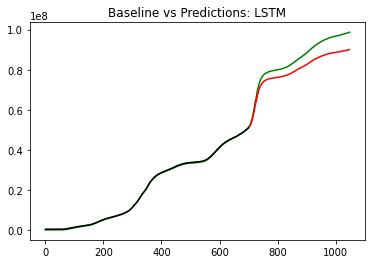

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color = 'green')
plt.plot(trainPredictPlot,color = 'black')
plt.plot(testPredictPlot, color = 'red')
plt.title("Baseline vs Predictions: LSTM")
plt.show()

### LSTM Window Method

In [16]:
# LSTM for international airline passengers problem with window regression framing


tf.random.set_seed(7)
## Repeating the steps done for LSTM 

# load the dataset
dataframe = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = get_dataset(train, look_back)
testX, testY = get_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
698/698 - 2s - loss: 0.0150 - 2s/epoch - 2ms/step
Epoch 2/100
698/698 - 1s - loss: 2.4864e-04 - 708ms/epoch - 1ms/step
Epoch 3/100
698/698 - 1s - loss: 1.4013e-05 - 666ms/epoch - 954us/step
Epoch 4/100
698/698 - 1s - loss: 1.4211e-05 - 659ms/epoch - 944us/step
Epoch 5/100
698/698 - 1s - loss: 1.4375e-05 - 721ms/epoch - 1ms/step
Epoch 6/100
698/698 - 1s - loss: 1.4975e-05 - 713ms/epoch - 1ms/step
Epoch 7/100
698/698 - 1s - loss: 1.4330e-05 - 679ms/epoch - 973us/step
Epoch 8/100
698/698 - 1s - loss: 1.5334e-05 - 696ms/epoch - 997us/step
Epoch 9/100
698/698 - 1s - loss: 1.5594e-05 - 723ms/epoch - 1ms/step
Epoch 10/100
698/698 - 1s - loss: 1.6399e-05 - 752ms/epoch - 1ms/step
Epoch 11/100
698/698 - 1s - loss: 1.7086e-05 - 722ms/epoch - 1ms/step
Epoch 12/100
698/698 - 1s - loss: 1.5904e-05 - 704ms/epoch - 1ms/step
Epoch 13/100
698/698 - 1s - loss: 1.5617e-05 - 704ms/epoch - 1ms/step
Epoch 14/100
698/698 - 1s - loss: 1.6826e-05 - 685ms/epoch - 981us/step
Epoch 15/100
698/698 - 1s 

In [17]:
# Predictions 

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train data Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test data Score: %.2f RMSE' % (testScore))

error = int(np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
mean = int(trainY[0].mean())
error_rate = round((error/mean),5)
error_rate

Train data Score: 203504.69 RMSE
Test data Score: 5096914.14 RMSE


0.00984

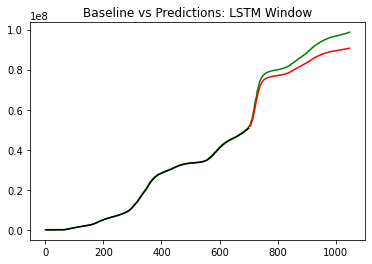

In [18]:
## Plotting Predictions

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color = 'green')
plt.plot(trainPredictPlot,color = 'black')
plt.plot(testPredictPlot, color = 'red')
plt.title("Baseline vs Predictions: LSTM Window")
plt.show()

In [19]:
def adf_test(series,title=''):

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string()) 
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis\nData has no unit root and Stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis\nData has a unit root and is Non-Stationary")

In [20]:
adf_test(covid_df['cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic         0.431061
p-value                    0.982620
# lags used               22.000000
# observations          1026.000000
critical value (1%)       -3.436740
critical value (5%)       -2.864361
critical value (10%)      -2.568272
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is Non-Stationary


We can see that our data is non-stationary by looking at the Augmented Dickey-Fuller Test results. We must change our from non-stationary to stationary in order for time series analysis to 

In [21]:
step_fit = auto_arima(covid_df['cases'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=3,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)           

step_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=26763.500, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=26647.192, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=26418.448, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=26761.502, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=26405.710, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=26371.976, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=26503.666, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=26371.795, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=26463.799, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=26084.977, Time=1.62 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=26124.051, Time=0.60 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=26218.634, Time=1.26 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=26321.674, Time=1.06 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=26082.836, Time=1.21 sec
 ARIMA(2,2,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1049
Model:               SARIMAX(3, 2, 2)   Log Likelihood              -13035.418
Date:                Mon, 05 Dec 2022   AIC                          26082.836
Time:                        21:42:51   BIC                          26112.558
Sample:                             0   HQIC                         26094.107
                               - 1049                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7610      0.008     92.499      0.000       0.745       0.777
ar.L2         -0.3928      0.008    -47.229      0.000      -0.409      -0.377
ar.L3         -0.2471      0.010    -24.231      0.000      -0.267      -0.227
ma.L1         -1.6285      0.007   -247.312      0.000      -1.641      -1.616
ma.L2          0.9297      0.006    159.714      0.000       0.918       0.941
sigma2      3.153e+09   1.27e-12   2.48e+21      0.000    3.15e+09    3.15e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.70   Jarque-Bera (JB):             28534.09
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              36.39   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.03e+36. Standard errors may be unstable.
"""

In [22]:
covid_df['cases_diff3'] = diff(covid_df['cases'],k_diff=2)

adf_test(covid_df['cases_diff3'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.054855e+00
p-value                 1.252234e-07
# lags used             2.000000e+01
# observations          1.026000e+03
critical value (1%)    -3.436740e+00
critical value (5%)    -2.864361e+00
critical value (10%)   -2.568272e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and Stationary


**AutoCorrelation Plot**

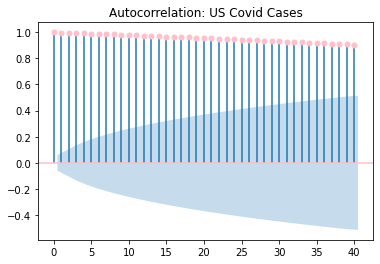

In [23]:
title = 'Autocorrelation: US Covid Cases'
lags = 40
plot_acf(covid_df['cases'],title=title,lags=lags, color = 'pink');

**Partial AutoCorrelation Plot**

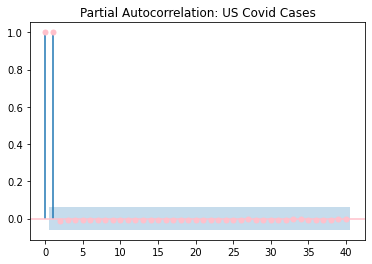

In [24]:
title = 'Partial Autocorrelation: US Covid Cases'
lags = 40
plot_pacf(covid_df['cases'],title=title,lags=lags, color ='pink');

**Testing the ARIMA Model on a small sample of data**

In [25]:
l = len(covid_df)
train = covid_df.iloc[:l-50]
test = covid_df.iloc[l-50:]

model = ARIMA(train['cases'],order=(2,2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.cases   No. Observations:                  997
Model:                 ARIMA(2, 2, 2)   Log Likelihood              -12444.901
Method:                       css-mle   S.D. of innovations          63684.459
Date:                Mon, 05 Dec 2022   AIC                          24901.802
Time:                        21:42:52   BIC                          24931.231
Sample:                    01-23-2020   HQIC                         24912.989
                         - 10-15-2022                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.7844    711.958      0.004      0.997   -1392.629    1398.197
ar.L1.D2.cases     0.8785      0.029     30.296      0.000       0.822       0.935
ar.L2.D2.cases    -0.5006      0.037    -13.622      0.000      -0.573      -0.429
ma.L1.D2.cases    -1.6906      0.019    -87.733      0.000      -1.728      -1.653
ma.L2.D2.cases     0.9103      0.011     82.590      0.000       0.889       0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8774           -1.1080j            1.4133           -0.1434
AR.2            0.8774           +1.1080j            1.4133            0.1434
MA.1            0.9286           -0.4860j            1.0481           -0.0767
MA.2            0.9286           +0.4860j            1.0481            0.0767
-----------------------------------------------------------------------------
"""

In [26]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,2) Predictions')

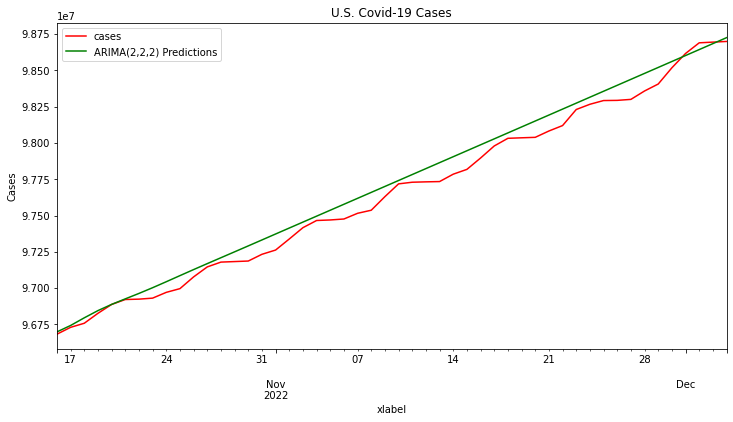

In [27]:
title = 'U.S. Covid-19 Cases'
ylabel='Cases'

ax = test['cases'].plot(legend=True,figsize=(12,6),title=title,color = 'red')
predictions.plot(legend=True,color='green')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='xlabel', ylabel=ylabel);

In [28]:
model_s = SARIMAX(train['cases'],order=(2,2,2),seasonal_order=(2,2,2,15))
results_s = model_s.fit()
results_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              cases   No. Observations:                  999
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 15)   Log Likelihood              -12610.820
Date:                            Mon, 05 Dec 2022   AIC                          25239.641
Time:                                    21:44:19   BIC                          25283.508
Sample:                                01-21-2020   HQIC                         25256.341
                                     - 10-15-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0363      0.171     -0.212      0.832      -0.372       0.300
ar.L2         -0.2645      0.051     -5.217      0.000      -0.364      -0.165
ma.L1         -0.6792      0.180     -3.771      0.000      -1.032      -0.326
ma.L2          0.0187      0.141      0.133      0.894      -0.257       0.294
ar.S.L15      -1.2098      0.188     -6.445      0.000      -1.578      -0.842
ar.S.L30      -0.4066      0.079     -5.171      0.000      -0.561      -0.252
ma.S.L15      -0.1420      0.182     -0.778      0.437      -0.500       0.216
ma.S.L30      -0.7864      0.185     -4.255      0.000      -1.149      -0.424
sigma2      2.284e+10   3.27e-11   6.99e+20      0.000    2.28e+10    2.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21511.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              58.93   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.38e+36. Standard errors may be unstable.
"""

In [29]:
error = int(np.sqrt(mean_squared_error(test.cases,predictions)))
mean = int(test.cases.mean())
error_rate = round((error/mean),5)
print('error: ', error, ' mean: ', mean,' error rate: ', error_rate)

error:  77855  mean:  97656327  error rate:  0.0008


Let's now train the ARIMA and SARIMA models on the full dataset using the optimum configuration we discovered using the above-mentioned processes to predict the number of cases in the future.

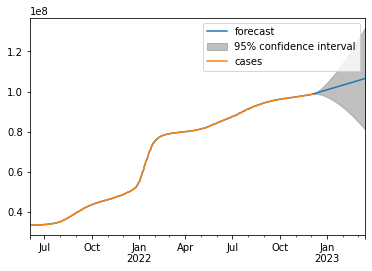

In [31]:
full_model = ARIMA(covid_df['cases'],order=(2,2,2))
full_results = full_model.fit()
fcast = full_results.plot_predict(start = int(500), end = int(len(covid_df)+100)) # Using the plot_predict to get the plot of future predictions and their confidence intervals

In [32]:
full_model1 = SARIMAX(covid_df['cases'],order=(2,2,2),seasonal_order=(2,2,2,15))
full_results1 = full_model1.fit(disp=True)
c = full_results1.get_forecast(100)
pred = full_results1.predict(start = int(len(covid_df)),end=int(len(covid_df)+100))

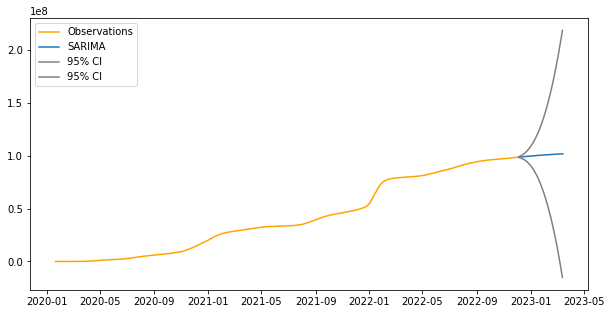

In [33]:
# for sarimax, there is no in-built function like plot_predict which gives the confidence interval with the predictions. So, we have used conf_int to first get the confidence intervals and then plot them using matplotlib.

plt.figure(figsize=(10,5))
l1, = plt.plot(covid_df['cases'], label = 'Observations',color = 'orange')
l2, = plt.plot(pred, label = 'SARIMA')
l3,l4 = plt.plot(c.conf_int(),label='95% CI',color='grey')

plt.legend(handles=[l1, l2,l3,l4])

Even though the error rate is 0.00098 for both the models, we can see that, as time goes on the confidence interval gets larger. Hence, we can conclude that these models are suitable for short time interval for predicting the cases in the future. 